In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import data
df0 = pd.read_csv("data/optogenetics_data_4-2023.csv")

# exp 586 had outlier efficacy of eMagAB 
exp586ind = df0.exp.values == "exp586"
df0 = df0.iloc[~exp586ind].copy()

df1 = pd.read_csv("data/optogenetics_data_6_30_23.csv")
df2 = pd.read_csv("data/230720_opto_data.csv")
df3 = pd.read_csv("data/230824-Lightsweep1-p2.csv")
df4 = pd.read_csv("data/230904-Hardval-output_CORRECTED.csv")
df5 = pd.read_csv("data/230907-validation3-output.csv")

# concatenate dataframes
df = pd.concat((df0, df1, df2, df3, df4, df5)).fillna(0.)

# add a "period_scaled" feature
df['period_scaled'] = df['period'] / df['period'].max()

df.describe()

,period,duty_cycle,intensity,value,min,max,efficacy,CRY2(535),CRY2FL,CRY2L348F,...,eMagAFB,eMagAFBF,eMagAFBM,EL222(AQTrip)b,EL222(AQTrip)e,EL222A79Q,GAVPOLT pGAL1,eMagABM Lex,eMagBA,period_scaled
count,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,...,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000,2176.000000
mean,84.092788,0.452717,0.515479,7093.654756,1989.718176,10153.233571,0.601342,0.047794,0.054228,0.066636,...,0.046875,0.073070,0.046875,0.042279,0.047335,0.059283,0.042279,0.058364,0.045956,0.350362
std,82.245403,0.295099,0.385055,5398.895150,1285.213070,6885.390366,0.313166,0.213379,0.226519,0.249448,...,0.211420,0.260311,0.211420,0.201272,0.212402,0.236208,0.201272,0.234484,0.209438,0.342665
min,0.050000,0.062500,0.000000,67.000000,59.000000,3221.250000,-0.117394,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000208
25%,15.000000,0.250000,0.098039,3305.250000,1650.000000,6081.500000,0.350255,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062496
50%,60.000000,0.500000,0.501961,5481.500000,1997.000000,8095.000000,0.619936,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.249983
75%,180.000000,0.750000,1.000000,8876.000000,2087.000000,12180.000000,0.880939,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.749948
max,240.016667,1.000000,1.000000,31976.000000,10488.250000,63341.500000,1.324084,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


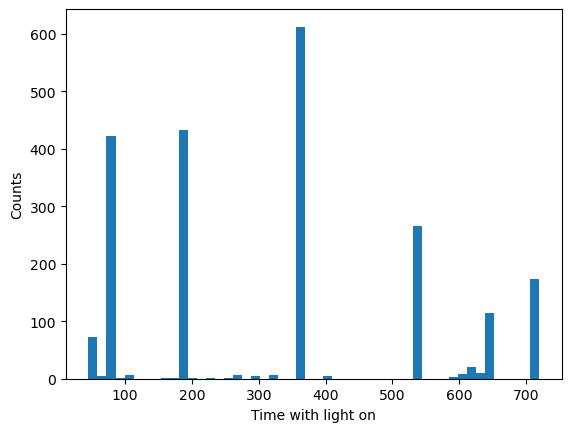

In [3]:
# determine total amount of time in minutes light was on for each sample 
total = (12*60) * df['duty_cycle'].values
plt.hist(total, bins=50)
plt.xlabel("Time with light on")
plt.ylabel("Counts")
plt.show()

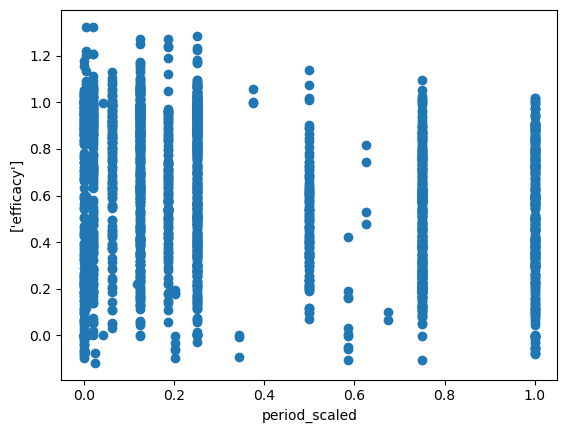

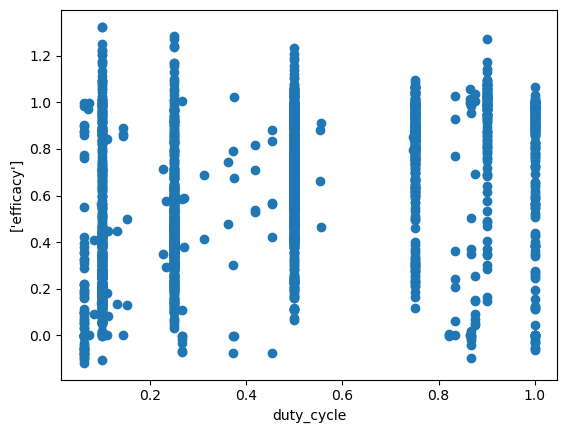

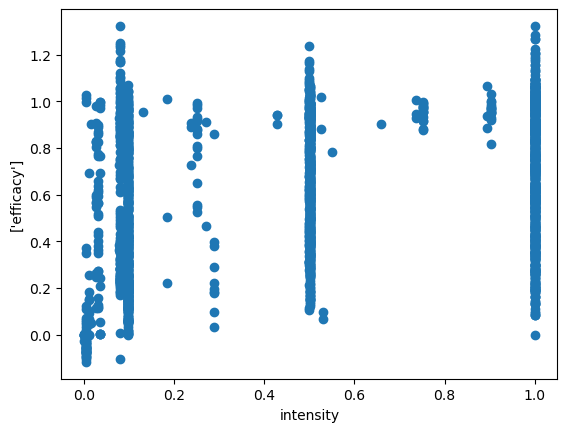

In [4]:
# plot correlations between features and response
features = ["period_scaled", "duty_cycle", "intensity"]
strains = list(df.columns.values[8:-1])
response = ["efficacy"]

for feature in features:
    plt.scatter(df[feature], df[response])
    plt.ylabel(response)
    plt.xlabel(feature)
    plt.show()

# Format data for multi-output model

In [5]:
# for each unique combination of features, identify efficacy of each transcription factor 
unique_ftrs, counts = np.unique(df[features].values, axis=0, return_counts=True)

multi_DF = pd.DataFrame()
for unique_ftr in unique_ftrs:

    # find indices of samples with same feature set 
    inds = [np.all(sample==unique_ftr) for sample in df[features].values]
    df_slice = df.iloc[inds].copy()

    df_efficacies = df_slice['efficacy'].values # df_slice['Value'].values/df_slice['Max'].values 
    sorted_efficacies = np.zeros(len(strains))

    for i,factor in enumerate(strains):
        factor_inds = np.array(df_slice[factor].values, bool)
        if any(factor_inds):
            # store average of replicates
            sorted_efficacies[i] = np.mean(df_efficacies[factor_inds])
        else:
            sorted_efficacies[i] = np.nan

    multi_df = pd.DataFrame()
    multi_df[features] = [unique_ftr]
    multi_df[strains]  = [sorted_efficacies]
    multi_DF = pd.concat((multi_DF, multi_df))

In [6]:
multi_DF.to_csv("data/Optosweep_multi_3.csv", index=False)

In [7]:
df4

,exp,period,duty_cycle,intensity,value,min,max,efficacy,CRY2(535),CRY2FL,...,CRY2W349R,EL222,EL222A79Q,GAVPOLT pGAL1,eMagAB,eMagABM,eMagABM Lex,eMagAFBF,eMagAFBM,eMagBA
0,exp0,1.000000,0.1,1.000000,2518,1865.25,4396.0,0.257927,0,0,...,0,0,0,0,1,0,0,0,0,0
1,exp1,1.000000,0.1,1.000000,2585,1865.25,4396.0,0.284402,0,0,...,0,0,0,0,1,0,0,0,0,0
2,exp2,1.000000,0.1,1.000000,2557,1865.25,4396.0,0.273338,0,0,...,0,0,0,0,1,0,0,0,0,0
3,exp3,1.000000,0.1,1.000000,2582,1865.25,4396.0,0.283216,0,0,...,0,0,0,0,1,0,0,0,0,0
4,exp4,180.000000,0.1,0.098039,2184,1865.25,4396.0,0.125951,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,exp255,60.000000,1.0,0.026316,8881,66.25,10742.5,0.825641,0,0,...,0,0,1,0,0,0,0,0,0,0
250,exp256,0.166667,0.5,0.078947,9896,66.25,10742.5,0.920712,0,0,...,0,0,1,0,0,0,0,0,0,0
251,exp257,180.000000,0.5,1.000000,6678,66.25,10742.5,0.619295,0,0,...,0,0,1,0,0,0,0,0,0,0
252,exp258,5.000000,0.5,0.078947,9763,66.25,10742.5,0.908254,0,0,...,0,0,1,0,0,0,0,0,0,0


# Make large design space

In [8]:
# define range of each feature
# period_space = np.logspace(-3.25, 0, 20)*240   # (~.13, ..., ~240)
period_space = np.array([.05, .1, .5, 1, 2, 2.5, 5, 10, 15, 20, 30, 90, 120, 150, 200, 240])
duty_space = np.logspace(-1.2, 0, 20)          # (~.06, ..., ~1)
intensity_space = np.array([1, 5, 10, 20, 30, 40, 50, 70, 90, 110, 120, 140, 170, 200, 230, 255]) / 255. # (1, ..., 255) / 255

#period_space = np.logspace(-3.25, 0, 6)*240   # (~.13, ..., ~240)
#duty_space = np.logspace(-1.2, 0, 6)          # (~.06, ..., ~1)
#intensity_space = np.array([1, 50, 110, 170, 230, 255]) / 255. # (1, ..., 255) / 255

# set up combinatorial design space  
space = []
for intensity in intensity_space:
    for duty in duty_space:
        if duty < 1:
            for period in period_space:
                    space.append(np.array([period/240, duty, intensity]))
        else:
            # period is 1 if light is always on 
            space.append(np.array([1., duty, intensity]))
            
df_design = pd.DataFrame(columns=features, data=space)

In [9]:
from scipy.special import comb 
comb(df_design.shape[0], 2)

11904760.0

In [10]:
df_design.to_csv("data/Optogenetics_design_space.csv", index=False)

In [14]:
# define range of each feature
period_space = np.array([.01, .1, 1, 5, 20, 50, 100, 150, 240])
duty_space = np.logspace(-1.2, 0, 8)          # (~.06, ..., ~1)
intensity_space = np.array([1, 5, 10, 50, 90, 120, 170, 210, 255]) / 255. # (1, ..., 255) / 255

# set up combinatorial design space  
space = []
for intensity in intensity_space:
    for duty in duty_space:
        if duty < 1:
            for period in period_space:
                    space.append(np.array([period/240, duty, intensity]))
        else:
            # period is 1 if light is always on 
            space.append(np.array([1., duty, intensity]))
            
df_design = pd.DataFrame(columns=features, data=space)

In [15]:
comb(df_design.shape[0], 2)

165600.0

In [16]:
df_design.to_csv("data/Optogenetics_design_space_mini.csv", index=False)